## 2. Data Cleaning, EDA and Modeling
---


In [120]:
!pip install wordcloud

In [121]:
#Imports
from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

%matplotlib inline

## EDA, Cleaning and Pre-processing
---

The dataset comprises reddit posts from 2 subreddits, r/cooking and r/baking and the goal is clean the data to aid our model in subsequent classification. 

General Approach: 

1. Check for null values. There are rows where 'Self Texts' is null hence 'Title' and 'Self texts' was combined for analysis.

2. 2 rows corresponding to posts that welcome newcomers to r/Baking were removed
3. Preprocessing, in this step, stop words related to the headers of the 2 subreddits will be removed 


In [122]:
combined_df= pd.read_csv('../datasets/data_to_clean.csv')

In [123]:
combined_df.head()

,Unnamed: 0,title,selftext,name,author,target
0,0,"Money has been tight this past month, so we’ve...",I typically save several dollars every trip to...,t3_esklbe,iScReAm612,1
1,1,I hate my own cooking,I have been learning how to cook over the past...,t3_esh9jv,nightglitter89x,1
2,2,Skip the fancy apron trend and get yer'self a ...,"Want that hip, macho aesthetic in the kitchen ...",t3_esnbr6,ProtoNate,1
3,3,My mom's measuring cup,Maybe this is about cooking. Maybe not. Since ...,t3_es3e31,ManosVanBoom,1
4,4,How can I make steamed vegetables taste more i...,"I eat a lot of steamed vegetables, particularl...",t3_ese5fw,TheTousler,1


In [124]:
combined_df.tail()

,Unnamed: 0,title,selftext,name,author,target
1769,1769,Hi! Any idea how we can compress raw food like...,NaN,t3_9t81vw,spit666999,0
1770,1770,Sugar cookies absorbed my royal icing,"Made a huge batch of sugar cookies, Flooded al...",t3_9srzqd,11_29_77,0
1771,1771,Dairy free scones?,Tried this recipe tonight:\n\nhttps://www.goda...,t3_9s8e64,hexagonalshit,0
1772,1772,Adding peanut butter to brownies,I would like to incorporate peanut butter (the...,t3_9rzllx,Icarus367,0
1773,1773,Salt Rising Bread Advice,A significant number of people in my area keep...,t3_9rx18w,SBouldrey,0


In [125]:
combined_df.shape

(1774, 6)

In [126]:
combined_df = combined_df.drop(columns='Unnamed: 0')

#### Dropping Posts

The 2 posts below from r/Baking will be dropped as they are posts stuck on top for newcomers to the subreddit thread


In [127]:
#drop baking post that is stuck to top for readers 
combined_df[786:788]

,title,selftext,name,author,target
786,Join Our Discord Server!,Need answers fast? Hoping to get help in real-...,t3_crm4hs,RecurvBow,0
787,FLAIR YOUR POSTS!,# This is an important notice from the Moderat...,t3_e1z1cn,RecurvBow,0


In [128]:
combined_df.drop([786,787], inplace=True)

In [129]:
print(combined_df.shape)

#check if 2 posts are removed 
combined_df[786:788]

(1772, 5)


,title,selftext,name,author,target
788,Recommendations for a mousse cake?,I'd like to make a mirror glaze mousse cake fo...,t3_esn5w7,young_salame,0
789,Sourdough Starter Container,So I've finally gone down the sourdough path a...,t3_esbf71,BobGoblin2,0


In [130]:
#check for null values 
combined_df.isnull().sum()

title        0
selftext    86
name         0
author       0
target       0
dtype: int64

In [131]:
#fill null values with a space before combining
combined_df['selftext'].fillna(" ", inplace=True)

In [132]:
#combine selftext and title 
combined_df['alltext'] = combined_df['title'] + " " + combined_df['selftext']

In [133]:
combined_df.alltext     #note: we did not reset index as it it not critical in this case

0       Money has been tight this past month, so we’ve...
1       I hate my own cooking I have been learning how...
2       Skip the fancy apron trend and get yer'self a ...
3       My mom's measuring cup Maybe this is about coo...
4       How can I make steamed vegetables taste more i...
                              ...                        
1769    Hi! Any idea how we can compress raw food like...
1770    Sugar cookies absorbed my royal icing Made a h...
1771    Dairy free scones? Tried this recipe tonight:\...
1772    Adding peanut butter to brownies I would like ...
1773    Salt Rising Bread Advice A significant number ...
Name: alltext, Length: 1772, dtype: object

In [134]:
combined_df.head()

,title,selftext,name,author,target,alltext
0,"Money has been tight this past month, so we’ve...",I typically save several dollars every trip to...,t3_esklbe,iScReAm612,1,"Money has been tight this past month, so we’ve..."
1,I hate my own cooking,I have been learning how to cook over the past...,t3_esh9jv,nightglitter89x,1,I hate my own cooking I have been learning how...
2,Skip the fancy apron trend and get yer'self a ...,"Want that hip, macho aesthetic in the kitchen ...",t3_esnbr6,ProtoNate,1,Skip the fancy apron trend and get yer'self a ...
3,My mom's measuring cup,Maybe this is about cooking. Maybe not. Since ...,t3_es3e31,ManosVanBoom,1,My mom's measuring cup Maybe this is about coo...
4,How can I make steamed vegetables taste more i...,"I eat a lot of steamed vegetables, particularl...",t3_ese5fw,TheTousler,1,How can I make steamed vegetables taste more i...


#### Establishing the Baseline Accuracy for Subseqent Modeling

The posts from the 2 subreddits are fairly balanced and ther baseline accuracy for subseqent modeling is 55.6%


In [135]:
#baseline model accuracy is 55.6%
combined_df['target'].value_counts(normalize=True)

0    0.556433
1    0.443567
Name: target, dtype: float64

In [136]:
lemmatizer = WordNetLemmatizer()

In [137]:
def review_words_lem (title):
    
    title =re.sub(r"https\S+","",str(title))
    
    # way to tokenize words
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+')
    
    #1. convert to lower case and split words by spaces
    words = tokenizer.tokenize(title.lower())
    
    #2. lemmatize words 
    lem_words = [lemmatizer.lemmatize(i) for i in words]
    
    #3. included stopwords  and convert stopwords to a set, as searching a set is faster than than a list
    addn_words=['cook','bake','cooking','baking']
    stops = stopwords.words('english')
    stops.extend(addn_words)
    
    #4. remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    #5. join words back into a string separated by a space
    
    return (" ".join(meaningful_words))

In [19]:
review_words_lem(combined_df['alltext'][0])

'money tight past month almost exclusively using store brands everything honestly barely notice difference taste wallet sure appreciates typically save several dollars every trip grocery store name brand refuse substitute store brand'

In [20]:
clean_reviews_2 = combined_df['alltext'].apply(review_words_lem) 

In [21]:
clean_reviews_2

0       money tight past month almost exclusively usin...
1       hate learning past year people tell gotten pre...
2       skip fancy apron trend get yer self welding ap...
3       mom measuring cup maybe maybe since personal e...
4       make steamed vegetables taste interesting stil...
                              ...                        
1769    hi idea compress raw food like special machine...
1770    sugar cookies absorbed royal icing made huge b...
1771    dairy free scones tried recipe tonight look gr...
1772    adding peanut butter brownies would like incor...
1773    salt rising bread advice significant number pe...
Name: alltext, Length: 1772, dtype: object

In [22]:
#to check that there are no null entries
clean_reviews_2.isnull().value_counts()

False    1772
Name: alltext, dtype: int64

#### EDA - overview of the length of posts 

From the histogram below, it can be seen that most of the posts are less than 2500 words with majority of the posts having less than 600 words. Mean number of words per post is 572. We have a fairly balanced set of posts with similar post lengths.

                  0
count   1772.000000
mean     572.384312
std      649.965252
min       11.000000
25%      267.750000
50%      429.500000
75%      700.000000
max    19088.000000


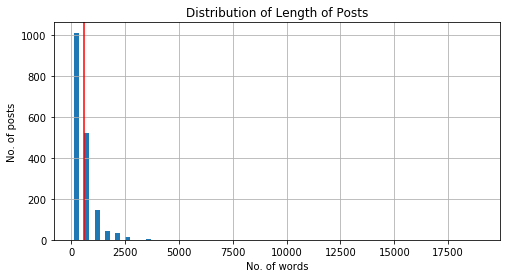

In [23]:
# comparing the length of posts 
# red line represents the mean number of words per post -> 572 words

#determine the length of each post and append to list
length = [len(text) for text in combined_df['alltext']]

#convert to dataframe to use .describe() to better understand the distribution
length_df = pd.DataFrame(length)
print(length_df.describe())

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(length, bins=40, rwidth=0.5)
plt.axvline(np.mean(length), color='red')
ax.set_title('Distribution of Length of Posts')
ax.set_xlabel('No. of words')
ax.set_ylabel('No. of posts')
ax.grid(b=True)

#### EDA - word cloud for each subreddit

A word cloud was generated for each subreddit, it can be seen that there are some overlapping words such as 'recipe', 'make' and 'use' that appear frequently in both subreddits. However, there are also distinctive words for each subreddit, in r/cooking we have 'sauce', 'chicken' and 'meat'. While r/baking gives us 'cake','cookie','butter' and 'dough'. Based on the distinctive words that appear in each subreddit, it looks like there is a chance to classify the posts despite the presence of similar words.  

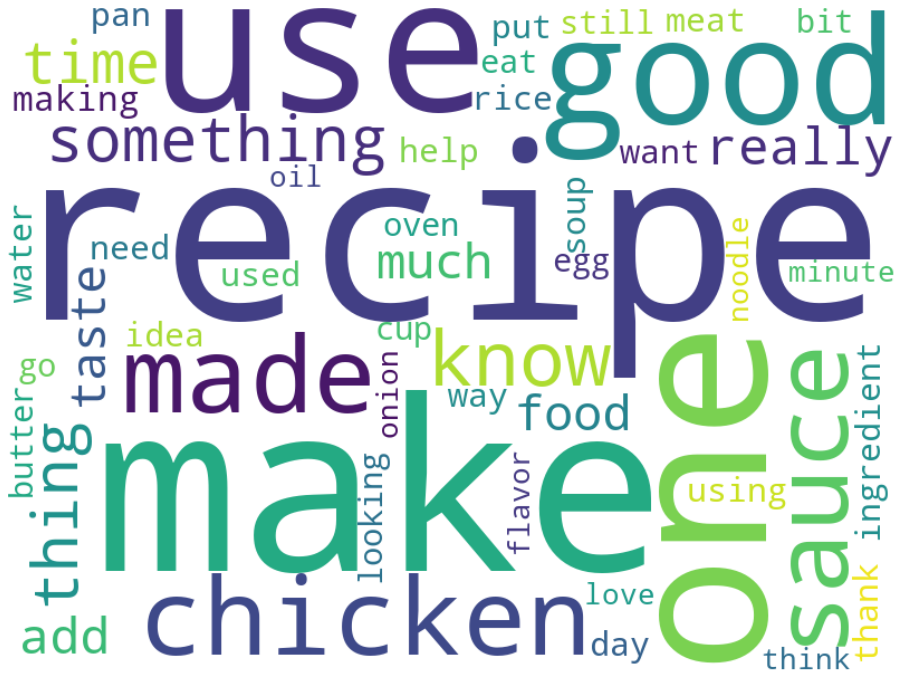

In [24]:
# generate a wordcloud for the respective subreddits

combined_df['lemm_text'] = clean_reviews_2

#masking function for the 2 subreddits
cooking = combined_df[combined_df['target']==1]
baking = combined_df[combined_df['target']==0]

#convert subreddit text to a single text
cooking_text = " ".join(post for post in cooking['lemm_text'])
baking_text = " ".join(post for post in baking['lemm_text'])

#plot word cloud for cooking 
wc_cook = WordCloud(max_words=50, width=800, height=600, 
              background_color='white', min_font_size =10).generate(cooking_text)

plt.figure(figsize=(16,16))
plt.imshow(wc_cook,interpolation='bilinear')
plt.axis("off")
plt.savefig('../figures/cooking_wordcloud.png');


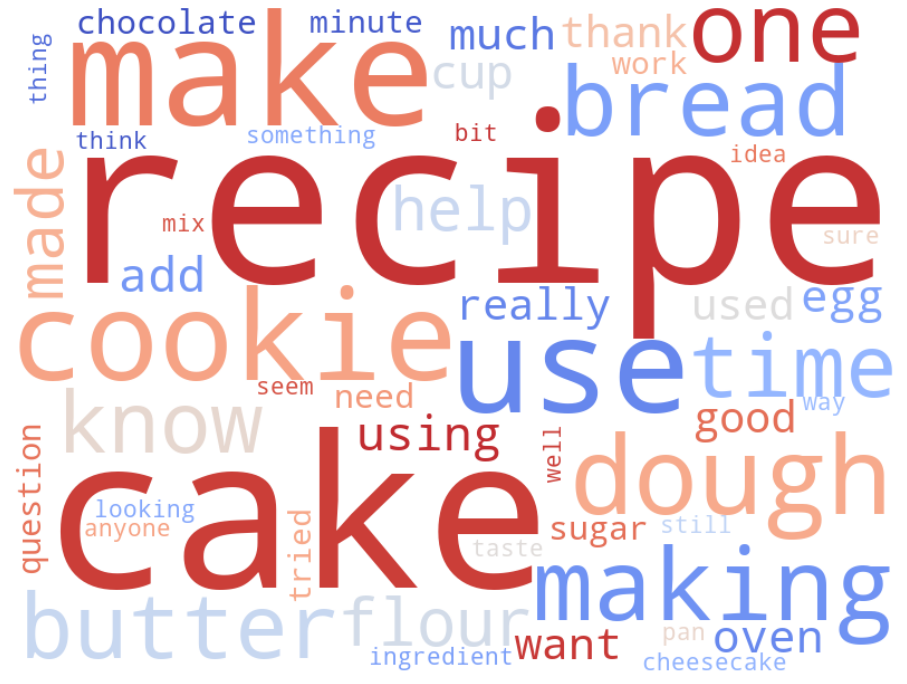

In [25]:
#plot word cloud for baking 
wc_bake = WordCloud(max_words=50, width=800, height=600, 
              background_color='white', min_font_size =10, colormap='coolwarm').generate(baking_text)

plt.figure(figsize=(16,16))
plt.imshow(wc_bake,interpolation='bilinear')
plt.axis("off")
plt.savefig('../figures/baking_wordcloud.png');

## Modeling
---

In this segment, we will use the following models to classify the reddit posts into their 2 subreddits, r/cooking and r/baking. 

Models Used: 
1. Logistic Regression Model 
2. Multinomial Naive Bayes Model 
3. Use of Grid Search to optimise the number of features in the count vectoriser in an attempt to improve model accuracy

Accuracy is likely the best metric to use here as improperly classifying a subreddit post is equally bad in this instance.

In [26]:
# using the lemmatised text 
X = clean_reviews_2
y = combined_df['target']

In [27]:
X.head()

0    money tight past month almost exclusively usin...
1    hate learning past year people tell gotten pre...
2    skip fancy apron trend get yer self welding ap...
3    mom measuring cup maybe maybe since personal e...
4    make steamed vegetables taste interesting stil...
Name: alltext, dtype: object


#### General Approach: 
1. Subreddit posts will be split into train and test set for validation and to determine model accuracy
2. Count Vectoriser to convert the text to numerical format 

In [28]:
# split into train and test set

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=10,
                                                    stratify=y)

In [29]:
X_train_2.shape

(1329,)

In [30]:
X_test_2.shape

(443,)

###### Count Vectoriser 

In this instance, the count vectoriser with the default max_features of 5000 will be used and we will use grid search to optimise later.

In [31]:
# Instantiate the "CountVectorizer" object
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) #this is maximum features, to get top 5000 words 

In [32]:
# fitting the model

train_data_features = cvec.fit_transform(X_train_2)

test_data_features = cvec.transform(X_test_2)    #use the same vocab to fit test reviews

# Numpy arrays are easy to work with, so convert the result to an array.
train_data_features = train_data_features.toarray()

In [33]:
# #get feature names here
# train_vectorize= pd.DataFrame(vec_cooking.toarray(), 
#                                       columns = cvec_cooking.get_feature_names())

In [34]:
type(train_data_features)

numpy.ndarray

In [35]:
train_data_features.shape

(1329, 5000)


#### A) Logistic Regression Model 

Findings: 
- The logistic regression model performed better than the baseline model, achieving 87.8% accuracy compared to the baseline accuracy of 55.6%. However the model seems to be an overfit as the score on the train data set (99.8%) is significantly higher than the test data set score of 87.8%. 
- In terms of predictions, there were slighlty more r/baking posts that were incorrectly predicted as compared to r/cooking posts.

In [36]:
lr = LogisticRegression()

In [37]:
# Fit model to training data.

lr_model = lr.fit(train_data_features, y_train_2)

C:\Users\leanne\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
# Evaluate model on training data.
#overfitting to train data set
lr_model.score(train_data_features, y_train_2)

0.9984951091045899

In [39]:
predictions = lr_model.predict(test_data_features)

In [40]:
# Evaluate model on testing data.
lr_model.score(test_data_features, y_test_2)

0.8781038374717833

In [41]:
cm = confusion_matrix(y_test_2,predictions)

cm_df_1 = pd.DataFrame(cm, 
                       columns = ['Pred Bake','Pred Cook'],
                      index = ['Actual Bake','Actual Cook'])
cm_df_1

,Pred Bake,Pred Cook
Actual Bake,216,30
Actual Cook,24,173


#### B) Multinomial Naive Bayes Model 

Findings: 
- The Multinomial NB model performed better than both the logistic regression (LR) and baseline model, achieving 91.8% accuracy. However the model seems to be an overfit as the score on the train data set (95.6%) is still higher than the test data set score of 91.8%. 
- In terms of predictions, there were slighlty more r/cooking posts that were incorrectly predicted as compared to r/baking posts.

In [42]:
# naive bayes model

nb = MultinomialNB()

nb_model = nb.fit(train_data_features, y_train_2)

In [43]:
predictions_nb = nb_model.predict(test_data_features)

In [44]:
nb_model.score(train_data_features, y_train_2)

0.9563581640331076

In [45]:
nb_model.score(test_data_features, y_test_2)

0.9187358916478555

In [46]:
cm_2 = confusion_matrix(y_test_2,predictions_nb)

cm_df_2 = pd.DataFrame(cm_2, 
                       columns = ['Pred Bake','Pred Cook'],
                      index = ['Actual Bake','Actual Cook'])
cm_df_2

,Pred Bake,Pred Cook
Actual Bake,239,7
Actual Cook,29,168


#### C) Grid Search to optimise Count Vectoriser for Multinomial NB Model 

Findings: 
- The multinomial NB model improved the test accuracy but the model was still overfitted. As such, a grid search was performed to see if we can optimise the number of features using count vectorizer to improve accuracy scores of the Multinomial NB model.
- The objective is to find the best parameters (such as the max_features, min_df, max_df and ngram) for the count vectoriser
- Based on the best parameters, the performance did not improve from the earlier Multinomial NB model. The model was still overfitted as the score on the train data set (95.2%) and the accuracy on the test data set score of 90.9%. We would have to find other means to improve model accuracy. 

In [47]:
# improved test set accuracy but the model is still overfitted
#use search grid to optimise number of words 
#view the distinct words for each category

In [48]:
#the naive bayes model performed better but it is still an overfit,
#using gridsearch to determine the optimal number of features

In [49]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [50]:
pipe_params = {
    'cvec__max_features': [2500, 3500, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train_2, y_train_2)
print(gs.best_score_)
gs.best_params_

0.8991723100075244


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [51]:
cvec_2 = CountVectorizer(max_features=3500,max_df=0.9, min_df=2)

In [52]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features_2 = cvec_2.fit_transform(X_train_2)

test_data_features_2 = cvec_2.transform(X_test_2)    #use the same vocab to fit test reviewsb

# Numpy arrays are easy to work with, so convert the result to an 
# array.
train_data_features_2 = train_data_features_2.toarray()

In [53]:
train_data_features_2.shape

(1329, 3500)

In [54]:
# naive bayes model

nb = MultinomialNB()

nb_model = nb.fit(train_data_features_2, y_train_2)

In [55]:
predictions_nb_2 = nb_model.predict(test_data_features_2)

In [56]:
nb_model.score(train_data_features_2, y_train_2)

0.9525959367945824

In [57]:
nb_model.score(test_data_features_2, y_test_2)

0.909706546275395

In [58]:
cm_3 = confusion_matrix(y_test_2,predictions_nb_2)

cm_df_3 = pd.DataFrame(cm_3, 
                       columns = ['Pred Bake','Pred Cook'],
                      index = ['Actual Bake','Actual Cook'])
cm_df_3

,Pred Bake,Pred Cook
Actual Bake,234,12
Actual Cook,28,169


In [59]:
# def review_words_stem (title):
#     #1. convert to lower case and split words by spaces
#     words = tokenizer.tokenize(title.lower())
    
#     #2. stem words 
#     lem_words = [lemmatizer.lemmatize(i) for i in words]
    
#     #3. convert stop words to a set, as searching a set is faster than 
#     #than a list
#     stops = set(stopwords.words('english'))
    
#     #4. remove stop words
#     meaningful_words = [w for w in words if not w in stops]
    
#     #5. join words back into a string separated by a space
    
#     return (" ".join(meaningful_words))

In [60]:
#split into test and train

## Analysis of Misclassified Posts
---

For the purpose of this analysis, we will use the model that scored the best B) Multinomal NB to analyse the misclassified posts. 


In [61]:
print(type(X_test_2))
print(type(y_test_2))
type(predictions_nb)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


numpy.ndarray

In [62]:
#concatenate predictions with X_test and y_test to identify the misclassified posts
pred = pd.DataFrame(predictions_nb,columns=['pred'],index=y_test_2.index)

agg_posts = pd.concat([X_test_2,y_test_2,pred],axis=1,sort=False)

In [63]:
agg_posts

,alltext,target,pred
1515,meringue cookies cake mom birthday coming want...,0,0
878,recipe cake jelly mousse sponge hi saw post re...,0,0
1734,mayonnaise substitute egg making one duncan hi...,0,0
1548,icing question making drip cakes things like y...,0,0
172,things learned life learning thing grateful si...,1,1
...,...,...,...
913,idea ingredients make inherited recipes grandm...,0,0
1268,ingredient measurement change question hello f...,0,0
1159,multiple jell layers help trying set multiple ...,0,0
1197,red velvet macarons hey made successful macaro...,0,0


In [64]:
#masking function for misclassified posts
agg_posts[agg_posts['target'] != agg_posts['pred']]

,alltext,target,pred
295,dumb maybe obvious question driscoll fruit dis...,1,0
734,solution issues,1,0
647,make dog treats faster hello everyone basicall...,1,0
678,fun making syrups simple syrups know never bot...,1,0
634,german recipe request hello hoping one might r...,1,0
192,little tricks tips techniques often included r...,1,0
1200,go dessert someone,0,1
356,sheets bend oven two cookie sheets lack better...,1,0
1769,hi idea compress raw food like special machine...,0,1
536,chocolate menu hello lovely people need help d...,1,0


In [92]:
misclass = agg_posts[agg_posts['target'] != agg_posts['pred']].index

Int64Index([ 295,  734,  647,  678,  634,  192, 1200,  356, 1769,  536,   84,
             106, 1554,  770,  173,  485,  387,  607,  457, 1208,  438,  157,
            1599,   20,  151,  733,  559,  360,  144,  305, 1584,  801,  758,
             226,  561,  513],
           dtype='int64')

In [ ]:
# from collections import Counter 

In [ ]:
# cooking_text = " ".join(post for post in cooking['lemm_text'])
# Counter()

#### Analysis of Posts Misclassified as r/AskBaking

Recap: There were 29 posts inaccurately classified as baking posts, this is higher compared to the 7 posts that were incorrectly classified as cooking posts. 

Analysis: The posts below were obtained from r/Cooking but it can be seen that the word 'cookies' appeared multiple times in the post which could have led the model to incorrectly classify this post. The third post had 'chocolate' which is a common word found in r/AskBaking which probably led to the misclassifications. 

In this case, the posts which seem to have more baking-related content were posted in the r/Cooking thread. This action is determined by the author and it may not be possible to correctly classify them when this situation arises. 


In [65]:
print('Incorrectly Classfied as r/AskingBaking post:')
print('================================================')
agg_posts['alltext'][513]

Incorrectly Classfied as r/AskingBaking post:


'vegan suitable coeliacs cookies expert kitchen turns today made great cookies soy flour sunflower oil sugar simple want make sort sandwich sorry english putting peanut butter middle two cookies problem since soy flour break easily wondering tip regarding making cookies make even tastier way making avoiding breaking cookies recommendations sort want sell delicious help appreciated want full recipe ask'

In [66]:
print('Incorrectly Classfied as r/AskingBaking post:')
print('================================================')
agg_posts['alltext'][356]

Incorrectly Classfied as r/AskingBaking post:


'sheets bend oven two cookie sheets lack better word bend oven minutes put sufficiently hot pop longer lay flat none cookie sheets happening cheap cookie sheets need replaced'

In [67]:
print('Incorrectly Classfied as r/AskingBaking post:')
print('================================================')
agg_posts['alltext'][438]

Incorrectly Classfied as r/AskingBaking post:


'adding lavender lemon zest white chocolate mousse boyfriend approaching important date us wanted surprise something thought mousse described really confused found lot different recipes mousse add heavy cream butter use egg yolks chocolate egg whites problem apparently consistent version latter end going route know add lemon lavender please help tremendously appreciate also know whether flavours work well together please let know'

In [68]:
# #### Analysis of Posts Misclassified as r/Cooking

# Recap: There were 7 posts that were incorrectly classified as cooking posts. 

# Analysis: The posts below had words such as '


In [69]:
print('Incorrectly Classfied as r/Cooking post:')
print('================================================')
agg_posts['alltext'][1208]

Incorrectly Classfied as r/Cooking post:


'giant box cheerios world use loss time proven eat intended would like use something knowledge well quite non existent almost cant think tasty way make use things stale'

In [70]:
print('Incorrectly Classfied as r/Cooking post:')
print('================================================')
agg_posts['alltext'][1554]

Incorrectly Classfied as r/Cooking post:


'compute production costs btw brownies already covered costs ingredients used including packaging cost making especially lpg oven costs level oven connected kg lpg tank temp time along pipe diameter taken consideration know compute production costs help please'

In [71]:
print('Incorrectly Classfied as r/Cooking post:')
print('================================================')
agg_posts['alltext'][801]

Incorrectly Classfied as r/Cooking post:


'start hi people totally sure proper subreddit goes university student living foreign country sadly find job thinking making income thing noobie dad expert ironically help lot cause works day basically wondering start easy dessert start sell thanks reading'

In [79]:
#prob for positive class
pos_class_prob_sorted = nb_model.feature_log_prob_[0, :].argsort()
#prob for negative class
neg_class_prob_sorted = nb_model.feature_log_prob_[1, :].argsort()

#getting the top features 
bake_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)
cook_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)

In [118]:
'greater' in list(bake_top_features)[-50:]

True

In [108]:
bake_top_features[-50:] #top10

array(['choices', 'phosphate', 'mainly', 'preppy', 'pulse', 'flowers',
       'guidelines', 'gross', 'pepperplate', 'nutella', 'considered',
       'bell', 'high', 'greater', 'parts', 'carbs', 'almond', 'chunk',
       'purchase', 'damage', 'cubes', 'large', 'honestly', 'receive',
       'anise', 'reasons', 'across', 'full', 'formed', 'loads', 'grain',
       'dumpling', 'left', 'moving', 'describe', 'harder', 'ravioli',
       'leave', 'footboard', 'famous', 'pizzas', 'diet', 'pulp', 'leeks',
       'hazan', 'man', 'require', 'case', 'form', 'fits'], dtype='<U22')

In [114]:
cook_top_features[:50]

array(['a3', 'chose', 'ml', 'chowders', 'mixes', 'chuck', 'mirror',
       'mirin', 'minor', 'minimum', 'circles', 'middle', 'microwaving',
       'methods', 'clafoutis', 'menu', 'clash', 'member', 'mom', 'melty',
       'chop', 'momofuku', 'cheapness', 'noticed', 'nothing', 'notes',
       'note', 'northern', 'nicely', 'never', 'chefs', 'neat', 'name',
       'myriad', 'mushrooms', 'multiple', 'moroccan', 'monstrosity',
       'monday', 'choosing', 'melts', 'meet', 'means', 'mail', 'college',
       'macerate', 'combined', 'combo', 'combos', 'lots'], dtype='<U22')

## Conclusion & Recommendations
---

- The Multinomial NB model using max features of 5000 was able to accurately classify 91.8% of the posts according to the subreddit and hence the model can be deployed for use. 
- However, the desire would be to futher improve the accuracy of the predictions and future work would include exploring other models such as Random Forests Classifier, Ensemble Techniques in order to get better scores. 
- In addition, during the EDA, we noticed that lemmetization did not reduce words to the similar root word. For example, 'make' and 'making' were both present in the word cloud and we may want to consider employ stemming during the pre-processing phase. 
- Lastly, future word also includes the use TF-IDF for feature extraction to see if the model score improves.

